##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TensorFlow 기반의 NumPy API

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://www.tensorflow.org/guide/tf_numpy"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org에서 보기</a>   </td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/guide/tf_numpy.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행</a></td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/guide/tf_numpy.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서 소스 보기</a>   </td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/guide/tf_numpy.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드</a></td>
</table>

## 개요

TensorFlow는 `tf.experimental.numpy`로 사용할 수 있는 [NumPy API](https://numpy.org/doc/1.16)의 하위 집합을 구현합니다. 이를 통해 TensorFlow에서 NumPy 코드를 빠르게 실행할 수 있으며 TensorFlow의 모든 API에 액세스할 수 있습니다.

## 설정


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.experimental.numpy as tnp
import timeit

print("Using TensorFlow version %s" % tf.__version__)

2022-12-14 21:24:26.806384: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 21:24:26.806474: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 21:24:26.806484: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


Using TensorFlow version 2.11.0


### NumPy 동작 사용

`tnp`를 NumPy로 사용하려면 TensorFlow에 대해 NumPy 동작을 활성화합니다.

In [3]:
tnp.experimental_enable_numpy_behavior()

이 호출은 TensorFlow에서 유형 승격을 활성화하고, 리터럴을 텐서로 변환할 때 유형 추론을 변경하여 NumPy 표준을 보다 엄격하게 따릅니다.

참고: 이 호출은 `tf.experimental.numpy` 모듈뿐만 아니라 전체 TensorFlow의 동작을 변경합니다.

## TensorFlow NumPy ND 배열

**ND 배열**이라는 `tf.experimental.numpy.ndarray`의 인스턴스는 특정 기기에 배치된 주어진 `dtype`의 다차원 고밀도 배열을 나타냅니다. 이것은 `tf.Tensor`에 대한 별칭입니다. `ndarray.T`, `ndarray.reshape`, `ndarray.ravel` 등과 같은 유용한 메서드를 위한 ND 배열 클래스를 확인해 보세요.

먼저 ND 배열 객체를 만든 다음, 다양한 메서드를 호출합니다. 

In [4]:
# Create an ND array and check out different attributes.
ones = tnp.ones([5, 3], dtype=tnp.float32)
print("Created ND array with shape = %s, rank = %s, "
      "dtype = %s on device = %s\n" % (
          ones.shape, ones.ndim, ones.dtype, ones.device))

# `ndarray` is just an alias to `tf.Tensor`.
print("Is `ones` an instance of tf.Tensor: %s\n" % isinstance(ones, tf.Tensor))

# Try commonly used member functions.
print("ndarray.T has shape %s" % str(ones.T.shape))
print("narray.reshape(-1) has shape %s" % ones.reshape(-1).shape)

Created ND array with shape = (5, 3), rank = 2, dtype = <dtype: 'float32'> on device = /job:localhost/replica:0/task:0/device:GPU:0

Is `ones` an instance of tf.Tensor: True

ndarray.T has shape (3, 5)
narray.reshape(-1) has shape (15,)


### 형식 승격

TensorFlow NumPy API에는 리터럴을 ND 배열로 변환하고 ND 배열 입력에 대해 형식 승격을 수행하기 위한 잘 정의된 의미 체계가 있습니다. 자세한 내용은 [`np.result_type`](https://numpy.org/doc/1.16/reference/generated/numpy.result_type.html)을 참조하세요.

TensorFlow API는 `tf.Tensor` 입력을 변경하지 않고 유형 승격을 수행하지 않는 반면, TensorFlow NumPy API는 NumPy 유형 승격 규칙에 따라 모든 입력을 승격합니다. 다음 예에서는 유형 승격을 수행합니다. 먼저, 서로 다른 유형의 ND 배열 입력에 추가를 실행하고 출력 유형을 기록합니다. 이러한 유형의 승격은 TensorFlow API에서 허용되지 않습니다.

In [5]:
print("Type promotion for operations")
values = [tnp.asarray(1, dtype=d) for d in
          (tnp.int32, tnp.int64, tnp.float32, tnp.float64)]
for i, v1 in enumerate(values):
  for v2 in values[i + 1:]:
    print("%s + %s => %s" % 
          (v1.dtype.name, v2.dtype.name, (v1 + v2).dtype.name))

Type promotion for operations
int32 + int64 => int64
int32 + float32 => float64
int32 + float64 => float64
int64 + float32 => float64
int64 + float64 => float64
float32 + float64 => float64


마지막으로, `ndarray.asarray`를 사용하여 리터럴을 ND 배열로 변환하고 결과 유형을 확인합니다.

In [6]:
print("Type inference during array creation")
print("tnp.asarray(1).dtype == tnp.%s" % tnp.asarray(1).dtype.name)
print("tnp.asarray(1.).dtype == tnp.%s\n" % tnp.asarray(1.).dtype.name)

Type inference during array creation
tnp.asarray(1).dtype == tnp.int64
tnp.asarray(1.).dtype == tnp.float64



리터럴을 ND 배열로 변환할 때 NumPy는 `tnp.int64` 및 `tnp.float64`와 같은 넓은 유형을 선호합니다. 반대로 `tf.convert_to_tensor`는 상수를 `tf.Tensor`로 변환하기 위해 `tf.int32` 및 `tf.float32` 유형을 선호합니다. TensorFlow NumPy API는 정수에 대한 NumPy 동작을 준수합니다. 부동 소수점의 경우, `experimental_enable_numpy_behavior`의 `prefer_float32` 인수를 사용하여 `tf.float64`에 비해 `tf.float32`를 선호할지 여부를 제어할 수 있습니다(기본적으로 `False`). 예를 들면 다음과 같습니다.

In [7]:
tnp.experimental_enable_numpy_behavior(prefer_float32=True)
print("When prefer_float32 is True:")
print("tnp.asarray(1.).dtype == tnp.%s" % tnp.asarray(1.).dtype.name)
print("tnp.add(1., 2.).dtype == tnp.%s" % tnp.add(1., 2.).dtype.name)

tnp.experimental_enable_numpy_behavior(prefer_float32=False)
print("When prefer_float32 is False:")
print("tnp.asarray(1.).dtype == tnp.%s" % tnp.asarray(1.).dtype.name)
print("tnp.add(1., 2.).dtype == tnp.%s" % tnp.add(1., 2.).dtype.name)

When prefer_float32 is True:
tnp.asarray(1.).dtype == tnp.float32
tnp.add(1., 2.).dtype == tnp.float32
When prefer_float32 is False:
tnp.asarray(1.).dtype == tnp.float64
tnp.add(1., 2.).dtype == tnp.float64


### 브로드캐스팅

TensorFlow와 유사하게 NumPy는 "브로드캐스팅" 값에 대한 풍부한 의미 체계를 정의합니다. 자세한 내용은 [NumPy 브로드캐스팅 가이드](https://numpy.org/doc/stable/user/basics.broadcasting.html)를 확인하고 [TensorFlow 브로드캐스팅 의미 체계](https://www.tensorflow.org/guide/tensor#broadcasting)와 비교할 수 있습니다.

In [8]:
x = tnp.ones([2, 3])
y = tnp.ones([3])
z = tnp.ones([1, 2, 1])
print("Broadcasting shapes %s, %s and %s gives shape %s" % (
    x.shape, y.shape, z.shape, (x + y + z).shape))

Broadcasting shapes (2, 3), (3,) and (1, 2, 1) gives shape (1, 2, 3)


### 인덱싱

NumPy는 매우 정교한 인덱싱 규칙을 정의합니다. [NumPy 인덱싱 가이드](https://numpy.org/doc/stable/reference/arrays.indexing.html)를 참조하세요. 아래 인덱스로 ND 배열을 사용합니다.

In [9]:
x = tnp.arange(24).reshape(2, 3, 4)

print("Basic indexing")
print(x[1, tnp.newaxis, 1:3, ...], "\n")

print("Boolean indexing")
print(x[:, (True, False, True)], "\n")

print("Advanced indexing")
print(x[1, (0, 0, 1), tnp.asarray([0, 1, 1])])

Basic indexing
tf.Tensor(
[[[16 17 18 19]
  [20 21 22 23]]], shape=(1, 2, 4), dtype=int64) 

Boolean indexing
tf.Tensor(
[[[ 0  1  2  3]
  [ 8  9 10 11]]

 [[12 13 14 15]
  [20 21 22 23]]], shape=(2, 2, 4), dtype=int64) 

Advanced indexing
tf.Tensor([12 13 17], shape=(3,), dtype=int64)


In [10]:
# Mutation is currently not supported
try:
  tnp.arange(6)[1] = -1
except TypeError:
  print("Currently, TensorFlow NumPy does not support mutation.")

Currently, TensorFlow NumPy does not support mutation.


### 예시 모델

다음으로, 모델을 만들고 추론을 실행하는 방법을 볼 수 있습니다. 이 간단한 모델은 relu 레이어와 직선 투영법(linear projection)을 적용합니다. 이후 섹션에서는 TensorFlow의 `GradientTape`를 사용하여 모델의 그래디언트를 계산하는 방법을 보여줍니다.

In [11]:
class Model(object):
  """Model with a dense and a linear layer."""

  def __init__(self):
    self.weights = None

  def predict(self, inputs):
    if self.weights is None:
      size = inputs.shape[1]
      # Note that type `tnp.float32` is used for performance.
      stddev = tnp.sqrt(size).astype(tnp.float32)
      w1 = tnp.random.randn(size, 64).astype(tnp.float32) / stddev
      bias = tnp.random.randn(64).astype(tnp.float32)
      w2 = tnp.random.randn(64, 2).astype(tnp.float32) / 8
      self.weights = (w1, bias, w2)
    else:
      w1, bias, w2 = self.weights
    y = tnp.matmul(inputs, w1) + bias
    y = tnp.maximum(y, 0)  # Relu
    return tnp.matmul(y, w2)  # Linear projection

model = Model()
# Create input data and compute predictions.
print(model.predict(tnp.ones([2, 32], dtype=tnp.float32)))

tf.Tensor(
[[ 0.63546157 -0.58499926]
 [ 0.63546157 -0.58499926]], shape=(2, 2), dtype=float32)


## TensorFlow NumPy 및 NumPy

TensorFlow NumPy는 전체 NumPy 사양의 하위 집합을 구현합니다. 시간이 지남에 따라 더 많은 기호가 추가되지만, 가까운 장래에 지원되지 않는 체계적인 기능이 있습니다. 여기에는 NumPy C API 지원, Swig 통합, Fortran 저장 순서, 뷰 및 `stride_tricks` 및 일부 `dtype`(예: `np.recarray` 및 `np.object`)이 포함됩니다. 자세한 내용은 [TensorFlow NumPy API 설명서](https://www.tensorflow.org/api_docs/python/tf/experimental/numpy)를 참조하세요.


### NumPy 상호 운용성

TensorFlow ND 배열은 NumPy 함수와 상호 운용될 수 있습니다. 이러한 객체는 `__array__` 인터페이스를 구현합니다. NumPy는 이 인터페이스를 사용하여 함수 인수를 처리하기 전에 `np.ndarray` 값으로 변환합니다.

마찬가지로, TensorFlow NumPy 함수는 `np.ndarray`를 포함하여 다양한 형식의 입력을 받을 수 있습니다. 이러한 입력은 `ndarray.asarray`를 호출하여 ND 배열로 변환됩니다.

ND 배열과 `np.ndarray` 간의 변환은 실제 데이터 복사를 트리거할 수 있습니다. 자세한 내용은 [버퍼 복사본](#Buffer-copies) 섹션을 참조하세요.

In [12]:
# ND array passed into NumPy function.
np_sum = np.sum(tnp.ones([2, 3]))
print("sum = %s. Class: %s" % (float(np_sum), np_sum.__class__))

# `np.ndarray` passed into TensorFlow NumPy function.
tnp_sum = tnp.sum(np.ones([2, 3]))
print("sum = %s. Class: %s" % (float(tnp_sum), tnp_sum.__class__))

sum = 6.0. Class: <class 'numpy.float64'>
sum = 6.0. Class: <class 'tensorflow.python.framework.ops.EagerTensor'>


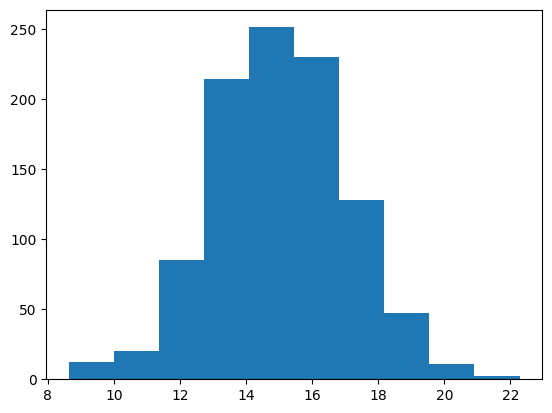

In [13]:
# It is easy to plot ND arrays, given the __array__ interface.
labels = 15 + 2 * tnp.random.randn(1, 1000)
_ = plt.hist(labels)

### 버퍼 복사본

TensorFlow NumPy와 NumPy 코드를 혼합하면 데이터 복사가 트리거될 수 있습니다. 이는 TensorFlow NumPy가 NumPy보다 메모리 정렬에 대한 요구 사항이 더 엄격하기 때문입니다.

`np.ndarray`가 TensorFlow Numpy에 전달되면 정렬 요구 사항을 확인하고 필요한 경우 복사본을 트리거합니다. ND 배열 CPU 버퍼를 NumPy에 전달할 때 일반적으로 버퍼는 정렬 요구 사항을 충족하며 NumPy는 복사본을 만들 필요가 없습니다.

ND 배열은 로컬 CPU 메모리가 아닌 기기에 배치된 버퍼를 참조할 수 있습니다. 이러한 경우, NumPy 함수를 호출하면 필요에 따라 네트워크 또는 기기에서 복사본이 트리거됩니다.

따라서 NumPy API 호출과의 혼합은 일반적으로 주의해서 수행해야 하며 사용자는 데이터 복사 오버헤드에 주의해야 합니다. TensorFlow NumPy 호출을 TensorFlow 호출과 인터리빙하는 것은 일반적으로 안전하며 데이터 복사를 방지합니다. 자세한 내용은 [tensorflow 상호 운용성](#tensorflow-interoperability) 섹션을 참조하세요.

### 연산자 우선 순위

TensorFlow NumPy는 NumPy보다 높은 `__array_priority__`를 정의합니다. 즉, ND 배열과 `np.ndarray`를 둘 다 포함하는 연산자의 경우, 전자가 우선합니다. 즉, `np.ndarray` 입력이 ND 배열로 변환되고 연산자의 TensorFlow NumPy 구현이 호출됩니다.

In [14]:
x = tnp.ones([2]) + np.ones([2])
print("x = %s\nclass = %s" % (x, x.__class__))

x = tf.Tensor([2. 2.], shape=(2,), dtype=float64)
class = <class 'tensorflow.python.framework.ops.EagerTensor'>


## TF NumPy 및 TensorFlow

TensorFlow NumPy는 TensorFlow를 기반으로 하므로 TensorFlow와 원활하게 상호 운용됩니다.

### `tf.Tensor` 및 ND 배열

ND 배열은 `tf.Tensor`에 대한 별칭이므로 실제 데이터 복사를 트리거하지 않고 서로 혼합될 수 있습니다.

In [15]:
x = tf.constant([1, 2])
print(x)

# `asarray` and `convert_to_tensor` here are no-ops.
tnp_x = tnp.asarray(x)
print(tnp_x)
print(tf.convert_to_tensor(tnp_x))

# Note that tf.Tensor.numpy() will continue to return `np.ndarray`.
print(x.numpy(), x.numpy().__class__)

tf.Tensor([1 2], shape=(2,), dtype=int32)
tf.Tensor([1 2], shape=(2,), dtype=int32)
tf.Tensor([1 2], shape=(2,), dtype=int32)
[1 2] <class 'numpy.ndarray'>


### TensorFlow 상호 운용성

ND 배열은 단지 `tf.Tensor`에 대한 별칭이기 때문에 ND 배열을 TensorFlow API에 전달할 수 있습니다. 앞서 언급했듯이, 이러한 상호 연산은 가속기 또는 원격 기기에 있는 데이터의 경우에도 실제로 데이터 복사를 수행하지 않습니다.

반대로, `tf.Tensor` 객체는 데이터 복사를 수행하지 않고 `tf.experimental.numpy` API로 전달할 수 있습니다.

In [16]:
# ND array passed into TensorFlow function.
tf_sum = tf.reduce_sum(tnp.ones([2, 3], tnp.float32))
print("Output = %s" % tf_sum)

# `tf.Tensor` passed into TensorFlow NumPy function.
tnp_sum = tnp.sum(tf.ones([2, 3]))
print("Output = %s" % tnp_sum)

Output = tf.Tensor(6.0, shape=(), dtype=float32)
Output = tf.Tensor(6.0, shape=(), dtype=float32)


### 그래디언트 및 야고비 행렬식: tf.GradientTape

TensorFlow의 GradientTape는 TensorFlow 및 TensorFlow NumPy 코드를 통한 역전파에 사용할 수 있습니다.

[예시 모델](#example-model) 섹션에서 생성된 모델을 사용하고 그래디언트와 야고비 행렬식을 계산합니다.

In [17]:
def create_batch(batch_size=32):
  """Creates a batch of input and labels."""
  return (tnp.random.randn(batch_size, 32).astype(tnp.float32),
          tnp.random.randn(batch_size, 2).astype(tnp.float32))

def compute_gradients(model, inputs, labels):
  """Computes gradients of squared loss between model prediction and labels."""
  with tf.GradientTape() as tape:
    assert model.weights is not None
    # Note that `model.weights` need to be explicitly watched since they
    # are not tf.Variables.
    tape.watch(model.weights)
    # Compute prediction and loss
    prediction = model.predict(inputs)
    loss = tnp.sum(tnp.square(prediction - labels))
  # This call computes the gradient through the computation above.
  return tape.gradient(loss, model.weights)

inputs, labels = create_batch()
gradients = compute_gradients(model, inputs, labels)

# Inspect the shapes of returned gradients to verify they match the
# parameter shapes.
print("Parameter shapes:", [w.shape for w in model.weights])
print("Gradient shapes:", [g.shape for g in gradients])
# Verify that gradients are of type ND array.
assert isinstance(gradients[0], tnp.ndarray)

Parameter shapes: [TensorShape([32, 64]), TensorShape([64]), TensorShape([64, 2])]
Gradient shapes: [TensorShape([32, 64]), TensorShape([64]), TensorShape([64, 2])]


In [18]:
# Computes a batch of jacobians. Each row is the jacobian of an element in the
# batch of outputs w.r.t. the corresponding input batch element.
def prediction_batch_jacobian(inputs):
  with tf.GradientTape() as tape:
    tape.watch(inputs)
    prediction = model.predict(inputs)
  return prediction, tape.batch_jacobian(prediction, inputs)

inp_batch = tnp.ones([16, 32], tnp.float32)
output, batch_jacobian = prediction_batch_jacobian(inp_batch)
# Note how the batch jacobian shape relates to the input and output shapes.
print("Output shape: %s, input shape: %s" % (output.shape, inp_batch.shape))
print("Batch jacobian shape:", batch_jacobian.shape)

Output shape: (16, 2), input shape: (16, 32)
Batch jacobian shape: (16, 2, 32)


### 추적 컴파일: tf.function

Tensorflow의 `tf.function`은 코드를 "추적 컴파일"한 다음 해당 추적을 최적화하여 훨씬 빠른 성능을 제공합니다. [그래프 및 함수 소개](./intro_to_graphs.ipynb)를 참조하세요.

`tf.function`은 TensorFlow NumPy 코드를 최적화하는 데에도 사용할 수 있습니다. 다음은 속도 향상을 보여주는 간단한 예입니다. `tf.function` 코드의 본문에는 TensorFlow NumPy API에 대한 호출이 포함됩니다.


In [19]:
inputs, labels = create_batch(512)
print("Eager performance")
compute_gradients(model, inputs, labels)
print(timeit.timeit(lambda: compute_gradients(model, inputs, labels),
                    number=10) * 100, "ms")

print("\ntf.function compiled performance")
compiled_compute_gradients = tf.function(compute_gradients)
compiled_compute_gradients(model, inputs, labels)  # warmup
print(timeit.timeit(lambda: compiled_compute_gradients(model, inputs, labels),
                    number=10) * 100, "ms")

Eager performance


2.3757479999403586 ms

tf.function compiled performance
0.5533262999961153 ms


### 벡터화: tf.vectorized_map

TensorFlow는 병렬 루프를 벡터화하는 기능을 내장하여 속도를 1~2배 높일 수 있습니다. 이러한 속도 향상은 `tf.vectorized_map` API를 통해 액세스할 수 있으며 TensorFlow NumPy 코드에도 적용됩니다.

해당 입력 배치 요소에 대해 배치에서 각 출력의 그래디언트를 계산하는 것이 때때로 유용합니다. 이러한 계산은 아래와 같이 `tf.vectorized_map` 을 사용하여 효율적으로 수행할 수 있습니다.

In [20]:
@tf.function
def vectorized_per_example_gradients(inputs, labels):
  def single_example_gradient(arg):
    inp, label = arg
    return compute_gradients(model,
                             tnp.expand_dims(inp, 0),
                             tnp.expand_dims(label, 0))
  # Note that a call to `tf.vectorized_map` semantically maps
  # `single_example_gradient` over each row of `inputs` and `labels`.
  # The interface is similar to `tf.map_fn`.
  # The underlying machinery vectorizes away this map loop which gives
  # nice speedups.
  return tf.vectorized_map(single_example_gradient, (inputs, labels))

batch_size = 128
inputs, labels = create_batch(batch_size)

per_example_gradients = vectorized_per_example_gradients(inputs, labels)
for w, p in zip(model.weights, per_example_gradients):
  print("Weight shape: %s, batch size: %s, per example gradient shape: %s " % (
      w.shape, batch_size, p.shape))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Weight shape: (32, 64), batch size: 128, per example gradient shape: (128, 32, 64) 
Weight shape: (64,), batch size: 128, per example gradient shape: (128, 64) 
Weight shape: (64, 2), batch size: 128, per example gradient shape: (128, 64, 2) 


In [21]:
# Benchmark the vectorized computation above and compare with
# unvectorized sequential computation using `tf.map_fn`.
@tf.function
def unvectorized_per_example_gradients(inputs, labels):
  def single_example_gradient(arg):
    inp, label = arg
    return compute_gradients(model,
                             tnp.expand_dims(inp, 0),
                             tnp.expand_dims(label, 0))

  return tf.map_fn(single_example_gradient, (inputs, labels),
                   fn_output_signature=(tf.float32, tf.float32, tf.float32))

print("Running vectorized computation")
print(timeit.timeit(lambda: vectorized_per_example_gradients(inputs, labels),
                    number=10) * 100, "ms")

print("\nRunning unvectorized computation")
per_example_gradients = unvectorized_per_example_gradients(inputs, labels)
print(timeit.timeit(lambda: unvectorized_per_example_gradients(inputs, labels),
                    number=10) * 100, "ms")

Running vectorized computation


0.5938215000242053 ms

Running unvectorized computation


37.777394899967476 ms


### 기기 배치

TensorFlow NumPy는 CPU, GPU, TPU 및 원격 기기에 연산을 배치할 수 있습니다. 기기 배치를 위한 표준 TensorFlow 메커니즘을 사용합니다. 아래의 간단한 예는 모든 기기를 나열한 다음 특정 기기에 계산을 배치하는 방법을 보여줍니다.

TensorFlow에는 또한 기기 간에 계산을 복제하고 여기에서 다루지 않을 집단 감소(collective reduction)를 수행하기 위한 API가 있습니다.

#### 기기 나열하기

`tf.config.list_logical_devices` 및 `tf.config.list_physical_devices`를 사용하여 사용할 기기를 찾을 수 있습니다.

In [22]:
print("All logical devices:", tf.config.list_logical_devices())
print("All physical devices:", tf.config.list_physical_devices())

# Try to get the GPU device. If unavailable, fallback to CPU.
try:
  device = tf.config.list_logical_devices(device_type="GPU")[0]
except IndexError:
  device = "/device:CPU:0"

All logical devices: [LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU'), LogicalDevice(name='/device:GPU:1', device_type='GPU'), LogicalDevice(name='/device:GPU:2', device_type='GPU'), LogicalDevice(name='/device:GPU:3', device_type='GPU')]
All physical devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]


#### 연산 배치하기: **`tf.device`**

`tf.device` 범위에서 호출하여 기기에 연산을 배치할 수 있습니다.


In [23]:
print("Using device: %s" % str(device))
# Run operations in the `tf.device` scope.
# If a GPU is available, these operations execute on the GPU and outputs are
# placed on the GPU memory.
with tf.device(device):
  prediction = model.predict(create_batch(5)[0])

print("prediction is placed on %s" % prediction.device)

Using device: LogicalDevice(name='/device:GPU:0', device_type='GPU')
prediction is placed on /job:localhost/replica:0/task:0/device:GPU:0


#### 기기 간에 ND 배열 복사하기: **`tnp.copy`**

특정 기기 범위에 배치된 `tnp.copy`를 호출하면 데이터가 해당 기기에 이미 있는 경우를 제외하고 해당 기기에 데이터를 복사합니다.

In [24]:
with tf.device("/device:CPU:0"):
  prediction_cpu = tnp.copy(prediction)
print(prediction.device)
print(prediction_cpu.device)

/job:localhost/replica:0/task:0/device:GPU:0
/job:localhost/replica:0/task:0/device:CPU:0


## 성능 비교

TensorFlow NumPy는 CPU, GPU, TPU에서 디스패치될 수 있는 고도로 최적화된 TensorFlow 커널을 사용합니다. TensorFlow는 또한 연산 융합과 같은 많은 컴파일러 최적화를 수행하며, 이는 성능 및 메모리 개선으로 이어집니다. 자세한 내용은 [Gradler를 사용한 TensorFlow 그래프 최적화](./graph_optimization.ipynb)를 참조하세요.

그러나 TensorFlow는 NumPy와 비교하여 디스패치 연산에 대한 오버헤드가 더 높습니다. 소규모 연산(약 10마이크로초 미만)으로 구성된 워크로드의 경우 이러한 오버헤드가 런타임에서 우세할 수 있으며 NumPy가 더 나은 성능을 제공할 수 있습니다. 다른 경우에는 일반적으로 TensorFlow가 더 나은 성능을 제공합니다.

아래 벤치마크를 실행하여 다양한 입력 크기에서 NumPy와 TensorFlow Numpy의 성능을 비교해 보세요.

In [25]:
def benchmark(f, inputs, number=30, force_gpu_sync=False):
  """Utility to benchmark `f` on each value in `inputs`."""
  times = []
  for inp in inputs:
    def _g():
      if force_gpu_sync:
        one = tnp.asarray(1)
      f(inp)
      if force_gpu_sync:
        with tf.device("CPU:0"):
          tnp.copy(one)  # Force a sync for GPU case

    _g()  # warmup
    t = timeit.timeit(_g, number=number)
    times.append(t * 1000. / number)
  return times


def plot(np_times, tnp_times, compiled_tnp_times, has_gpu, tnp_times_gpu):
  """Plot the different runtimes."""
  plt.xlabel("size")
  plt.ylabel("time (ms)")
  plt.title("Sigmoid benchmark: TF NumPy vs NumPy")
  plt.plot(sizes, np_times, label="NumPy")
  plt.plot(sizes, tnp_times, label="TF NumPy (CPU)")
  plt.plot(sizes, compiled_tnp_times, label="Compiled TF NumPy (CPU)")
  if has_gpu:
    plt.plot(sizes, tnp_times_gpu, label="TF NumPy (GPU)")
  plt.legend()

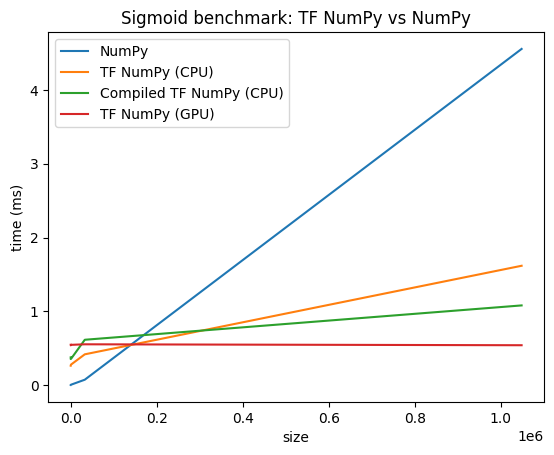

In [26]:
# Define a simple implementation of `sigmoid`, and benchmark it using
# NumPy and TensorFlow NumPy for different input sizes.

def np_sigmoid(y):
  return 1. / (1. + np.exp(-y))

def tnp_sigmoid(y):
  return 1. / (1. + tnp.exp(-y))

@tf.function
def compiled_tnp_sigmoid(y):
  return tnp_sigmoid(y)

sizes = (2 ** 0, 2 ** 5, 2 ** 10, 2 ** 15, 2 ** 20)
np_inputs = [np.random.randn(size).astype(np.float32) for size in sizes]
np_times = benchmark(np_sigmoid, np_inputs)

with tf.device("/device:CPU:0"):
  tnp_inputs = [tnp.random.randn(size).astype(np.float32) for size in sizes]
  tnp_times = benchmark(tnp_sigmoid, tnp_inputs)
  compiled_tnp_times = benchmark(compiled_tnp_sigmoid, tnp_inputs)

has_gpu = len(tf.config.list_logical_devices("GPU"))
if has_gpu:
  with tf.device("/device:GPU:0"):
    tnp_inputs = [tnp.random.randn(size).astype(np.float32) for size in sizes]
    tnp_times_gpu = benchmark(compiled_tnp_sigmoid, tnp_inputs, 100, True)
else:
  tnp_times_gpu = None
plot(np_times, tnp_times, compiled_tnp_times, has_gpu, tnp_times_gpu)

## 추가 자료

- [TensorFlow NumPy: Distributed Image Classification Tutorial](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/ops/numpy_ops/g3doc/TensorFlow_Numpy_Distributed_Image_Classification.ipynb)
- [TensorFlow NumPy: Keras and Distribution Strategy](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/ops/numpy_ops/g3doc/TensorFlow_NumPy_Keras_and_Distribution_Strategy.ipynb)
- [Sentiment Analysis with Trax and TensorFlow NumPy](https://github.com/google/trax/blob/master/trax/tf_numpy_and_keras.ipynb)